The notebook for creating movie for sea surface height and temperature anomalies wrt 1958-2012 mean JRA55 forced global MOM6 simulation. 

In [1]:
import xarray as xr
import numpy as np
from xgcm import Grid
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [15]:
def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.6)
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.FixedLocator(np.arange(-60,81,30))
    #gl.xlocator = mticker.FixedLocator(np.arange(-360,360,60))
    #gl.xlocator = mticker.FixedLocator([-120, -60, 0, 60, 120])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.set_adjustable('datalim')
    
    ax.set_aspect(1.0)
    
    _ = plt.title(title, fontsize=14)
    return fig

In [3]:
path = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/"

ppdir = "OM4p25_JRA55do1.4_0netfw_cycle6_extradiags_v3/gfdl.ncrc4-intel18-prod/pp/"

ds_grid = xr.open_dataset(path + ppdir + "ocean_annual/ocean_annual.static.nc")

ds1 = xr.open_mfdataset(path + ppdir + "ocean_annual/ts/annual/5yr/*zos.nc")
ds2 = xr.open_mfdataset(path + ppdir + "ocean_annual/ts/annual/5yr/*tos.nc")

ds = xr.merge([ds1, ds2, ds_grid])

print(ds)

<xarray.Dataset>
Dimensions:       (nv: 2, time: 55, xh: 1440, xq: 1440, yh: 1080, yq: 1080)
Coordinates:
  * nv            (nv) float64 1.0 2.0
  * time          (time) object 1958-07-02 12:00:00 ... 2012-07-02 00:00:00
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables:
    average_DT    (time) timedelta64[ns] dask.array<chunksize=(5,), meta=np.ndarray>
    average_T1    (time) datetime64[ns] dask.array<chunksize=(5,), meta=np.ndarray>
    average_T2    (time) datetime64[ns] dask.array<chunksize=(5,), meta=np.ndarray>
    time_bnds     (time, nv) timedelta64[ns] dask.array<chunksize=(5, 2), meta=np.ndarray>
    zos           (time, yh, xh) float32 dask.array<chunksize=(5, 1080, 1440), meta=np.ndarray>


In [5]:
ssh = (ds['zos'] - ds['zos'].mean('time')).assign_coords({'geolat': ds['geolat'], 'geolon': ds['geolon']})
sst = (ds['tos'] - ds['tos'].mean('time')).assign_coords({'geolat': ds['geolat'], 'geolon': ds['geolon']})

In [11]:
ds['time.year'].values[0]

1958

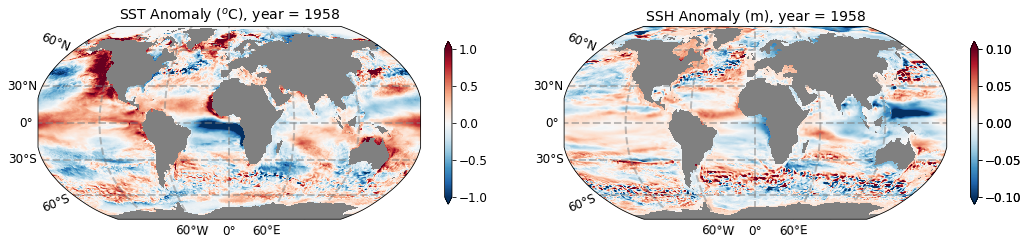

In [14]:
grid1 = plt.GridSpec(1, 2, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,5])

lat_lon_ext = [-180, 180, -85., 85.]

i = 0 

tmp = sst.isel(time=i)
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-1.0, vmax=1.0, vstep=0.2, lat_lon_ext = lat_lon_ext,
            lon='geolon', lat='geolat', cmap='RdBu_r', title=r'SST Anomaly ($^o$C), year = ' + str(ds['time.year'].values[i]))

tmp = ssh.isel(time=i)
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-0.1, vmax=0.1, vstep=0.2, lat_lon_ext = lat_lon_ext,
            lon='geolon', lat='geolat', cmap='RdBu_r', title=r'SSH Anomaly (m), year = ' + str(ds['time.year'].values[i]))

ax.remove()

tmp = ssh.isel(time=i)
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-0.1, vmax=0.1, vstep=0.2, lat_lon_ext = lat_lon_ext,
            lon='geolon', lat='geolat', cmap='RdBu_r', title=r'SSH Anomaly (m), year = ' + str(ds['time.year'].values[i]))

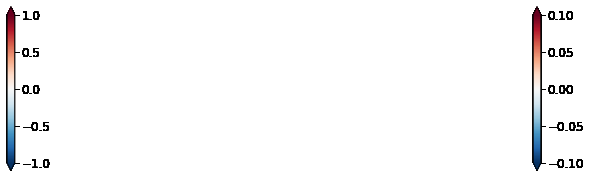

In [16]:
# Define the meta data for the movie
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='SST and SSH', artist='Matplotlib',
                comment='Surface anomaly fields from JRA55 forced global simulation')
writer = FFMpegWriter(fps=3, metadata=metadata)

grid1 = plt.GridSpec(1, 2, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,5])
lat_lon_ext = [-180, 180, -85., 85.]

with writer.saving(fig, "/home/Hemant.Khatri/Videos/SST_SSH.gif", 300): # set dpi
    
    for i in range(0, len(ds.time)):
        
        tmp = sst.isel(time=i)
        ax1 = fig.add_subplot(grid1[0, 0], projection=ccrs.Robinson(),facecolor='grey')
        _ = plot_sec(ax1, tmp, vmin=-1.0, vmax=1.0, vstep=0.2, lat_lon_ext = lat_lon_ext,
                     lon='geolon', lat='geolat', cmap='RdBu_r', 
                     title=r'SST Anomaly ($^o$C), year = ' + str(ds['time.year'].values[i]))

        tmp = ssh.isel(time=i)
        ax2 = fig.add_subplot(grid1[0, 1], projection=ccrs.Robinson(),facecolor='grey')
        _ = plot_sec(ax2, tmp, vmin=-0.1, vmax=0.1, vstep=0.2, lat_lon_ext = lat_lon_ext,
                     lon='geolon', lat='geolat', cmap='RdBu_r', 
                     title=r'SSH Anomaly (m), year = ' + str(ds['time.year'].values[i]))
        
        plt.tight_layout()
        
        writer.grab_frame()
        
        ax1.remove()
        ax2.remove()